In [9]:
# Timetable Generation as a Constraint Satisfaction Problem
## Comparison: 
### (a) Backtracking with Variable & Value Ordering (MRV + LCV)
### (b) Backtracking with Forward Checking


Sample Timetable (Backtracking with MRV + LCV):
{'C1': ('T1', 'R1', 'Slot1'), 'C2': ('T2', 'R2', 'Slot1'), 'C3': ('T1', 'R1', 'Slot2'), 'C4': ('T1', 'R1', 'Slot3')}

Sample Timetable (Forward Checking):
{'C1': ('T1', 'R1', 'Slot1'), 'C2': ('T1', 'R1', 'Slot2'), 'C3': ('T1', 'R1', 'Slot3'), 'C4': ('T1', 'R1', 'Slot4')}


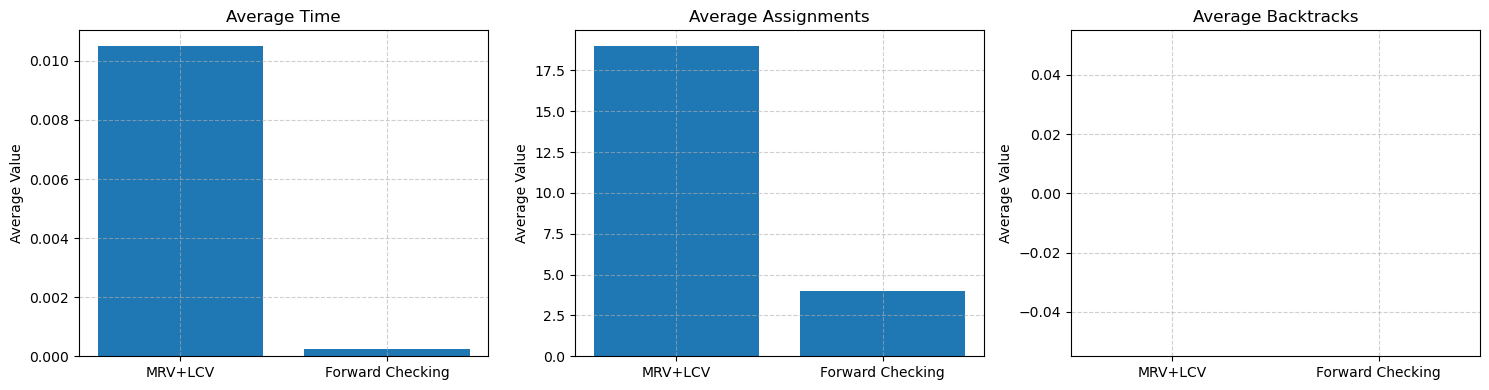

In [10]:
import random
import time
import matplotlib.pyplot as plt

# ----------------------------
# Data Setup
# ----------------------------
courses = ["C1", "C2", "C3", "C4"]
teachers = ["T1", "T2", "T3", "T4"]
rooms = ["R1", "R2"]
slots = ["Slot1", "Slot2", "Slot3", "Slot4"]

# Constraints
def is_valid(assignment, course, value):
    t, r, s = value

    # check teacher-room-slot conflicts
    for c, (t2, r2, s2) in assignment.items():
        if s == s2:
            if t == t2:  # same teacher in same slot
                return False
            if r == r2:  # same room in same slot
                return False
    return True

# ----------------------------
# Utility: MRV and LCV
# ----------------------------
def mrv(variables, domains, assignment):
    unassigned = [v for v in variables if v not in assignment]
    return min(unassigned, key=lambda var: len(domains[var]))

def lcv(var, domains, assignment):
    # Least constraining value: count how many conflicts each value causes
    def conflicts(value):
        count = 0
        for other_var in domains:
            if other_var not in assignment and other_var != var:
                for v2 in domains[other_var]:
                    if not is_valid({**assignment, var: value}, other_var, v2):
                        count += 1
        return count
    return sorted(domains[var], key=lambda val: conflicts(val))

# ----------------------------
# Backtracking with MRV + LCV
# ----------------------------
def backtracking_mrv_lcv(variables, domains, assignment):
    global assign_count_1, backtrack_count_1
    if len(assignment) == len(variables):
        return assignment

    var = mrv(variables, domains, assignment)
    for value in lcv(var, domains, assignment):
        assign_count_1 += 1
        if is_valid(assignment, var, value):
            assignment[var] = value
            result = backtracking_mrv_lcv(variables, domains, assignment)
            if result:
                return result
            del assignment[var]
            backtrack_count_1 += 1
    return None

# ----------------------------
# Forward Checking
# ----------------------------
def forward_checking(variables, domains, assignment):
    global assign_count_2, backtrack_count_2
    if len(assignment) == len(variables):
        return assignment

    unassigned = [v for v in variables if v not in assignment]
    var = unassigned[0]

    for value in domains[var]:
        assign_count_2 += 1
        if is_valid(assignment, var, value):
            assignment[var] = value
            # Update domains for forward checking
            new_domains = {v: list(d) for v, d in domains.items()}
            for other in unassigned:
                if other != var:
                    new_domains[other] = [val for val in new_domains[other] if is_valid(assignment, other, val)]

            # if any domain becomes empty → backtrack
            if all(new_domains[v] for v in unassigned if v != var):
                result = forward_checking(variables, new_domains, assignment)
                if result:
                    return result

            del assignment[var]
            backtrack_count_2 += 1
    return None

# ----------------------------
# Running Experiments
# ----------------------------
def run_experiment(trials=10):
    results = {"MRV+LCV": {"time": [], "assignments": [], "backtracks": []},
               "Forward Checking": {"time": [], "assignments": [], "backtracks": []}}

    variables = courses
    all_values = [(t, r, s) for t in teachers for r in rooms for s in slots]

    for _ in range(trials):
        domains = {var: list(all_values) for var in variables}

        # Backtracking with MRV+LCV
        global assign_count_1, backtrack_count_1
        assign_count_1 = 0
        backtrack_count_1 = 0
        start = time.time()
        result1 = backtracking_mrv_lcv(variables, domains, {})
        end = time.time()
        results["MRV+LCV"]["time"].append(end - start)
        results["MRV+LCV"]["assignments"].append(assign_count_1)
        results["MRV+LCV"]["backtracks"].append(backtrack_count_1)

        # Forward Checking
        global assign_count_2, backtrack_count_2
        assign_count_2 = 0
        backtrack_count_2 = 0
        start = time.time()
        result2 = forward_checking(variables, domains, {})
        end = time.time()
        results["Forward Checking"]["time"].append(end - start)
        results["Forward Checking"]["assignments"].append(assign_count_2)
        results["Forward Checking"]["backtracks"].append(backtrack_count_2)

    return results, result1, result2

# ----------------------------
# Run & Compare
# ----------------------------
results, result1, result2 = run_experiment(trials=10)

print("Sample Timetable (Backtracking with MRV + LCV):")
print(result1)
print("\nSample Timetable (Forward Checking):")
print(result2)

# ----------------------------
# Plotting Comparison
# ----------------------------
def plot_results(results):
    algorithms = list(results.keys())
    metrics = ["time", "assignments", "backtracks"]

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    for i, metric in enumerate(metrics):
        avg_values = [sum(results[alg][metric])/len(results[alg][metric]) for alg in algorithms]
        axes[i].bar(algorithms, avg_values)
        axes[i].set_title(f"Average {metric.capitalize()}")
        axes[i].set_ylabel("Average Value")
        axes[i].grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

plot_results(results)



=== MRV+LCV ===
Assignments: 35
Backtracks: 0
Time (s): 0.0143
Solution:
  Math -> Teacher: T1, Timeslot: Mon-9, Room: R1
  Physics -> Teacher: T1, Timeslot: Mon-10, Room: R1
  Chemistry -> Teacher: T1, Timeslot: Tue-9, Room: R1
  Biology -> Teacher: T1, Timeslot: Tue-10, Room: R1
  English -> Teacher: T1, Timeslot: Wed-9, Room: R1

=== Forward Checking ===
Assignments: 5
Backtracks: 0
Time (s): 0.0017
Solution:
  Math -> Teacher: T1, Timeslot: Mon-9, Room: R1
  Physics -> Teacher: T1, Timeslot: Mon-10, Room: R1
  Chemistry -> Teacher: T1, Timeslot: Tue-9, Room: R1
  Biology -> Teacher: T1, Timeslot: Tue-10, Room: R1
  English -> Teacher: T1, Timeslot: Wed-9, Room: R1


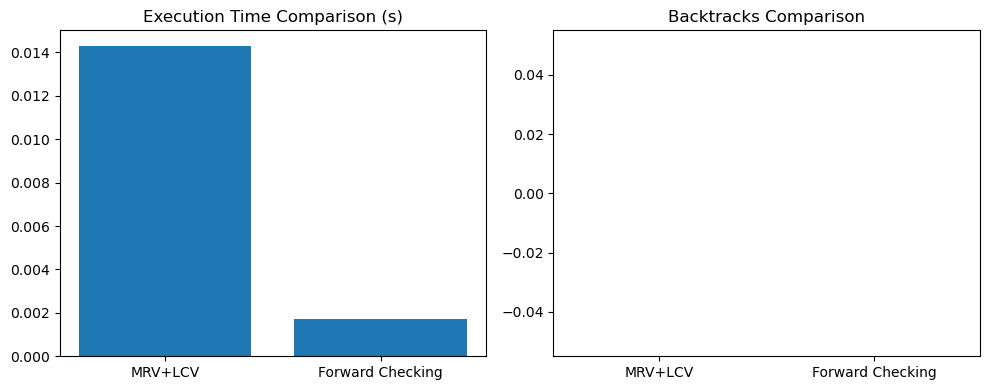

In [11]:
import random
import time
import matplotlib.pyplot as plt

# ---------------------------------------------
# Problem Setup
# ---------------------------------------------
courses = ["Math", "Physics", "Chemistry", "Biology", "English"]
teachers = ["T1", "T2", "T3", "T4", "T5"]
timeslots = ["Mon-9", "Mon-10", "Tue-9", "Tue-10", "Wed-9"]
rooms = ["R1", "R2", "R3"]

# Each course must be assigned (Teacher, Timeslot, Room)
variables = courses

# Constraints:
# 1. A teacher cannot teach two courses at the same time.
# 2. A room cannot host two courses at the same time.
# 3. Each course must be assigned to exactly one slot and one room.


# ---------------------------------------------
# Utility Functions
# ---------------------------------------------
def is_consistent(assignment, var, value):
    """Check if assigning value to var is consistent with existing assignment."""
    teacher, timeslot, room = value
    for other_var, other_value in assignment.items():
        o_teacher, o_timeslot, o_room = other_value
        # Constraint 1: teacher cannot teach two courses at same time
        if teacher == o_teacher and timeslot == o_timeslot:
            return False
        # Constraint 2: room cannot host two courses at same time
        if room == o_room and timeslot == o_timeslot:
            return False
    return True


def get_domain():
    """Generate domain for each variable."""
    domain = []
    for t in teachers:
        for ts in timeslots:
            for r in rooms:
                domain.append((t, ts, r))
    return domain


domains = {var: get_domain() for var in variables}


# ---------------------------------------------
# MRV + LCV Backtracking
# ---------------------------------------------
def mrv(assignment, domains):
    unassigned = [v for v in variables if v not in assignment]
    return min(unassigned, key=lambda var: len(domains[var]))


def lcv(var, domains, assignment):
    values = domains[var]
    # Prefer values that rule out the fewest options for other variables
    def conflicts(value):
        count = 0
        teacher, timeslot, room = value
        for other_var in variables:
            if other_var != var and other_var not in assignment:
                for v in domains[other_var]:
                    if (teacher == v[0] and timeslot == v[1]) or (room == v[2] and timeslot == v[1]):
                        count += 1
        return count
    return sorted(values, key=conflicts)


def backtrack_mrv_lcv(assignment, domains, metrics):
    if len(assignment) == len(variables):
        return assignment

    var = mrv(assignment, domains)
    for value in lcv(var, domains, assignment):
        metrics['assignments'] += 1
        if is_consistent(assignment, var, value):
            assignment[var] = value
            result = backtrack_mrv_lcv(assignment, domains, metrics)
            if result:
                return result
            del assignment[var]
            metrics['backtracks'] += 1
    return None


# ---------------------------------------------
# Forward Checking Backtracking
# ---------------------------------------------
def forward_check(var, value, domains):
    """Prune domains of other variables that conflict with value."""
    teacher, timeslot, room = value
    new_domains = {v: list(domains[v]) for v in domains}
    for other_var in variables:
        if other_var != var:
            new_domains[other_var] = [v for v in new_domains[other_var]
                                      if not ((teacher == v[0] and timeslot == v[1]) or
                                              (room == v[2] and timeslot == v[1]))]
    return new_domains


def backtrack_forward_check(assignment, domains, metrics):
    if len(assignment) == len(variables):
        return assignment

    var = mrv(assignment, domains)
    for value in domains[var]:
        metrics['assignments'] += 1
        if is_consistent(assignment, var, value):
            assignment[var] = value
            new_domains = forward_check(var, value, domains)
            result = backtrack_forward_check(assignment, new_domains, metrics)
            if result:
                return result
            del assignment[var]
            metrics['backtracks'] += 1
    return None


# ---------------------------------------------
# Run Experiments
# ---------------------------------------------
def run_experiment():
    methods = {
        "MRV+LCV": backtrack_mrv_lcv,
        "Forward Checking": backtrack_forward_check
    }

    results = {}
    for method_name, func in methods.items():
        assignment = {}
        metrics = {"assignments": 0, "backtracks": 0}
        start = time.time()
        solution = func(assignment, {v: list(domains[v]) for v in variables}, metrics)
        end = time.time()
        metrics["time"] = round(end - start, 4)
        results[method_name] = {"solution": solution, "metrics": metrics}

    return results


# ---------------------------------------------
# Run & Display
# ---------------------------------------------
results = run_experiment()

for method, data in results.items():
    print(f"\n=== {method} ===")
    print("Assignments:", data["metrics"]["assignments"])
    print("Backtracks:", data["metrics"]["backtracks"])
    print("Time (s):", data["metrics"]["time"])
    print("Solution:")
    for c, val in data["solution"].items():
        print(f"  {c} -> Teacher: {val[0]}, Timeslot: {val[1]}, Room: {val[2]}")


# ---------------------------------------------
# Visualization
# ---------------------------------------------
labels = list(results.keys())
times = [results[m]["metrics"]["time"] for m in labels]
backtracks = [results[m]["metrics"]["backtracks"] for m in labels]

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.bar(labels, times)
plt.title("Execution Time Comparison (s)")

plt.subplot(1, 2, 2)
plt.bar(labels, backtracks)
plt.title("Backtracks Comparison")

plt.tight_layout()
plt.show()
